<a href="https://colab.research.google.com/github/Josh0527/Uber-Stcok-Prediction-Model/blob/main/Stock_Prediction_Model_(Uber).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import .csv file

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")

print("Path to dataset files:", path)

#confirm file name
os.listdir(path)


Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/world-stock-prices-daily-updating/versions/303


['World-Stock-Prices-Dataset.csv']

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pytz
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings

In [33]:
#import dataset
df = pd.read_csv(path + "/World-Stock-Prices-Dataset.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-03-25 00:00:00-04:00,7.290000,7.380000,7.150000,7.290000,9921100.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-03-25 00:00:00-04:00,113.269997,114.949997,112.709999,114.809998,29012400.0,0.0,0.0,amd,AMD,technology,usa,NaN
2,2025-03-25 00:00:00-04:00,120.889999,122.449997,120.419998,120.879997,35800.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
3,2025-03-25 00:00:00-04:00,278.899994,279.790009,276.209991,279.279999,2767600.0,0.0,0.0,american express,AXP,finance,usa,NaN
4,2025-03-25 00:00:00-04:00,25.549999,26.170000,25.480000,25.480000,100.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN


In [34]:
df.Brand_Name.unique() #return unique values

array(['peloton', 'amd', 'adidas', 'american express', 'puma', 'visa',
       'adobe', 'unilever', 'cisco', 'jpmorgan chase & co', 'lvmh',
       'airbnb', 'marriott', 'zoominfo', 'toyota', 'hilton', "mcdonald's",
       'the home depot', 'mastercard', 'johnson & johnson', 'uber',
       'procter & gamble', 'coinbase', 'fedex', '3m', 'nordstrom',
       'philips', 'foot locker', 'netflix', 'the coca-cola company',
       'ubisoft', 'crocs', 'southwest airlines', 'shopify', 'amazon',
       'apple', 'nike', 'target', 'google', 'spotify',
       'zoom video communications', 'the walt disney company', 'roblox',
       'nintendo', 'delta air lines', 'microsoft', 'costco',
       'american eagle outfitters', 'hershey company', 'tesla',
       'pinterest', 'bmw group', 'chipotle', 'porsche', 'logitech',
       'colgate palmolive', 'salesforce / slack', 'nvidia', 'starbucks',
       'honda', 'block'], dtype=object)

In [35]:
df1 = df[['Date', 'Close', 'Brand_Name']] #return data and close for a brands
df1.head(2)

,Date,Close,Brand_Name
0,2025-03-25 00:00:00-04:00,7.290000,peloton
1,2025-03-25 00:00:00-04:00,114.809998,amd


In [36]:
#filter for uber only
df2 = df1[df1['Brand_Name'] == 'uber']

In [37]:
df2.head(2), df2.shape

(                          Date      Close Brand_Name
 20   2025-03-25 00:00:00-04:00  75.610001       uber
 116  2025-03-24 00:00:00-04:00  76.510002       uber,
 (1523, 3))

In [38]:
df3 = df2[['Date', 'Close']]
df3.tail(4)

,Date,Close
90944,2019-05-15 00:00:00-04:00,41.290001
90973,2019-05-14 00:00:00-04:00,39.959999
91015,2019-05-13 00:00:00-04:00,37.099998
91112,2019-05-10 00:00:00-04:00,41.570000


In [39]:
#view data info
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1523 entries, 20 to 91112
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1523 non-null   object 
 1   Close   1523 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.7+ KB


In [40]:
#convert to local time
#convert to Datetime
def str_to_dt(date):
    x = pd.to_datetime(date)  # Convert string to datetime
    if x.tzinfo is None:  # Check if naive (no timezone)
        x = x.tz_localize("UTC")  # Localize to UTC
    lagos_tz = pytz.timezone("Africa/Lagos")  # Define Lagos timezone
    return x.tz_convert(lagos_tz)  # Convert to Lagos time

#check
date_str = "2024-01-29 12:00:00"
converted_date = str_to_dt(date_str)
print(converted_date)

2024-01-29 13:00:00+01:00


In [41]:
warnings.filterwarnings

df3['Date'] = df3['Date'].apply(str_to_dt)
df3['Date']

,Date
20,2025-03-25 05:00:00+01:00
116,2025-03-24 05:00:00+01:00
173,2025-03-21 05:00:00+01:00
202,2025-03-21 05:00:00+01:00
297,2025-03-20 05:00:00+01:00
...,...
90882,2019-05-16 05:00:00+01:00
90944,2019-05-15 05:00:00+01:00
90973,2019-05-14 05:00:00+01:00
91015,2019-05-13 05:00:00+01:00


In [42]:
#set dtype
warnings.filterwarnings

df3['Date'] = pd.to_datetime(df3['Date']).dt.date
df3.Date

,Date
20,2025-03-25
116,2025-03-24
173,2025-03-21
202,2025-03-21
297,2025-03-20
...,...
90882,2019-05-16
90944,2019-05-15
90973,2019-05-14
91015,2019-05-13


In [16]:
print(df3.isnull().sum())  # Check for NaNs in the 'Close' column
print(df3.index.isnull().sum())

Date     0
Close    0
dtype: int64
0


In [17]:
#index
df3.index = df3.pop('Date')
df3.head(2)

,Close
Date,
2025-03-25,75.610001
2025-03-24,76.510002


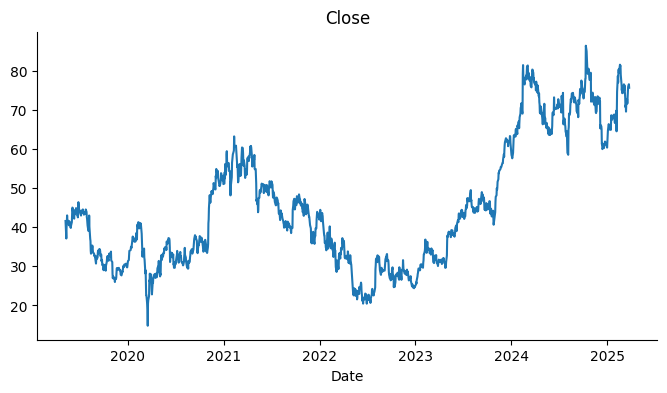

In [18]:
#plot time-series
plt.figure(figsize=(10, 6))
df3['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [21]:
#normalize by scaling
import warnings
warnings.filterwarnings('ignore')

scaler = MinMaxScaler()

df3['Close'] = scaler.fit_transform(df3[['Close']])

In [22]:
df3.Close

,Close
Date,
2025-03-25,0.849972
2025-03-24,0.862556
2025-03-21,0.853188
2025-03-21,0.853188
2025-03-20,0.832355
...,...
2019-05-16,0.394016
2019-05-15,0.370106
2019-05-14,0.351510


In [23]:
train = df3.iloc[:1029]
test = df3.iloc[1029:]

train.shape, test.shape

((1029, 1), (494, 1))

In [24]:
# Reshape
time_steps = 60  # Number of past time steps to look at
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(train['Close'].values[i-time_steps:i])  # 60 time steps
    y_train.append(train['Close'].values[i])  # Next day's price

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.0632
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0019
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0017
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0019
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0015
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0014
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 0.0014
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0013
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0011
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0011
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0011
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0010
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 9.4677e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 9.5825e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/

In [26]:
#Reshape test
time_steps = 60

X_test = []
y_test = []

#Use the test dataset to create sequences
for i in range(time_steps, len(test)):
    X_test.append(test['Close'].values[i-time_steps:i])  # 60 time steps
    y_test.append(test['Close'].values[i])  # Next day's price

#Convert lists to np arrays
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshape for LSTM input (samples, time steps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_test shape: {X_test.shape}")  # Should match X_train's shape
print(f"y_test shape: {y_test.shape}")  # Should be (samples,)

X_test shape: (434, 60, 1)
y_test shape: (434,)


In [27]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.4471e-04
Test Loss: 0.000470298487925902


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


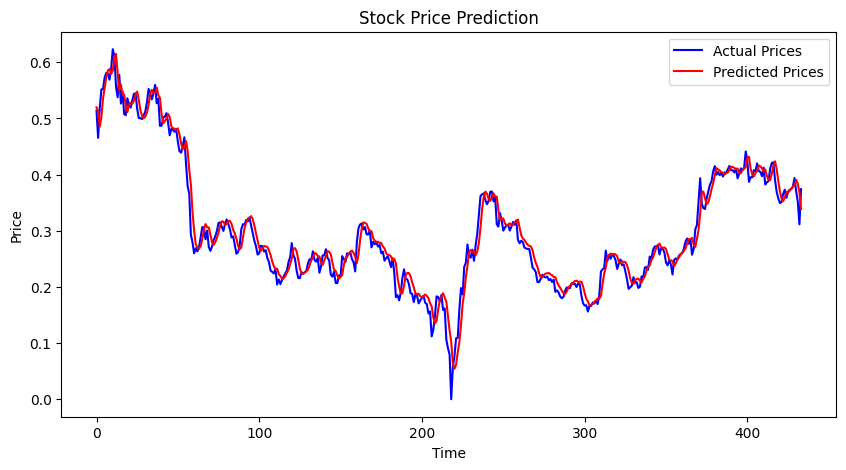

In [28]:
#plot
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
#DataFrame for comparison
df_results = pd.DataFrame({
    'Actual Price': y_test.flatten(),  # Flatten to 1D
    'Predicted Price': y_pred.flatten()  # Flatten to 1D
})

#Display as a table
print(df_results)

     Actual Price  Predicted Price
0        0.513982         0.519924
1        0.465464         0.512261
2        0.518736         0.485414
3        0.551874         0.501808
4        0.552153         0.535433
..            ...              ...
429      0.394016         0.381270
430      0.370106         0.390496
431      0.351510         0.383974
432      0.311521         0.368351
433      0.374021         0.338771

[434 rows x 2 columns]


In [30]:
#Check RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.021686366507044783
